This module:
    1. Calculate the data for actual __HOURY__ data __ONLY__
    2. Resave the file in correct format
    3. Write functions to automate these processes 
        ***getDeltaSeries() => replaceCseries()***
    4. Process all of the downloaded social data from the above guidelines and save

In [3]:
import os, sys
import pandas as pd 
import numpy as np
import requests 
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mticker
pd.set_option('display.max_columns', 999)
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
print(os.getcwd())

/Users/hn/Documents/USC Others/ISI Research/PumpCoin/CrytoCompare/All_Pump_Analysis/Final_Analysis


# PART 1: TRANSFORM DATA INTO TRUE TIME SERIES

## Test on a random coin 
Pandas can handle elementwise subtraction just fine. No need to turn into numpy. 
**BUT**
We see that some variables increase monotomously, while others are actual count (number of followers).
==> Must investigate this!

In [5]:
krl = pd.read_pickle("../../Social_Data/Hourly/Hourly_AE_190978.pkl")
krl = krl.reset_index(drop=True).drop_duplicates() ##Drop duplicates and reset index, otherwise messy!
krl_cols = krl.columns
krl.shape

(16001, 36)

In [6]:
krl[-2:]

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
16006,1577750400,120,75,308,10775,30899,795,2118,3082,763,2847,307,40811,2718,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,191,138,13,2640,65,378,52,2019-12-30 16:00:00,2019-12-31 00:00:00+00:00
16007,1577754000,120,75,308,10775,30899,795,2118,3082,763,2847,307,40811,2718,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,191,138,13,2640,65,378,52,2019-12-30 17:00:00,2019-12-31 01:00:00+00:00


In [12]:
a = krl.drop(['date','date_utc'],axis=1).loc[1:,:].reset_index(drop=True)
b = krl.drop(['date','date_utc'],axis=1).iloc[:-1,:].reset_index(drop=True)
b['time'] = 0
krl_final = a-b
print(krl_final.shape)
krl_final.head(2)

(16000, 34)


,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors
0,1520157600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0
1,1520161200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0


In [13]:
check_cols = []
for col in krl_final.columns:
    if any(krl_final[col] < 0): 
        check_cols.append(col)

In [14]:
def getSocialDelta(df: pd.DataFrame, delta: int, drop_cols: list = []):
    '''
    Given a dataframe with time series (OHLCV/Data), calculate the data points for each 
    t_x - t_delta. 
    Returns: a dataframe with the same shape as the original. 
    param df : Pandas dataframe with time series. 
    !!Must contain varibale time := UNIX timestamp for GMT zone as anchor 
    
    param delta: integer for the number of days/hours/secs to go back
    drop_cols: a list of columns names to exclude from consideration 
    '''
    if delta < 1: 
        print('Time delta must be an integer greater than 1')
        return None
    #The index can really mess things up!!!
    temp = df[['time'] + drop_cols]
    temp = temp.rename(columns = {'time':'time_temp'})
    a = df.drop(drop_cols,axis=1).loc[delta:,:].reset_index(drop=True)
    b = df.drop(drop_cols,axis=1).iloc[:-delta,:].reset_index(drop=True)
    b['time'] = 0
#     print("A shape",a.shape)
#     print("B shape",b.shape)
    f = a - b
       
    #Merge back the drop cols 
    final = pd.merge(left=f,left_on='time',right=temp,right_on='time_temp',how='left')
    final = final.drop('time_temp', axis=1)
    final = final.reset_index(drop=True).drop_duplicates()
    return final 


In [15]:
drop_cols = ['date','date_utc']
test = getSocialDelta(krl,1,drop_cols)
print(test.shape)

(16000, 36)


In [16]:
test[-3:]

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
15997,1577746800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-305,0.0,0.0,0.0,-0.01,0,0,0,0,0,0,0,0,2019-12-30 15:00:00,2019-12-30 23:00:00+00:00
15998,1577750400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,590,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,2019-12-30 16:00:00,2019-12-31 00:00:00+00:00
15999,1577754000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.00,0,0,0,0,0,0,0,0,2019-12-30 17:00:00,2019-12-31 01:00:00+00:00


## Categorize Social Media Variables

In [17]:
code = ['code_repo_stars',
'code_repo_forks' ,
'code_repo_subscribers',
'code_repo_open_pull_issues',
'code_repo_closed_pull_issues',
'code_repo_open_issues' ,
'code_repo_closed_issues']

In [18]:
twitter = ['twitter_followers',
'twitter_following',
'twitter_lists',
'twitter_favorites']

In [19]:
reddit = ['reddit_subscribers',
'reddit_active_users',
'reddit_posts_per_hour',
'reddit_post_per_day',
'reddit_comments_per_hour',
'reddit_cooments_per_day'
]

In [20]:
fb = ['fb_likes','fb_talking_about']

In [21]:
market = [
'comments',
'posts',
'followers' ,
'points',
'overview_page_views',
'analysis_page_views',
'markets_page_views',
'charts_page_views',
'trades_page_views',
'forum_page_views',
'influence_page_views',
'total_page_views'
]

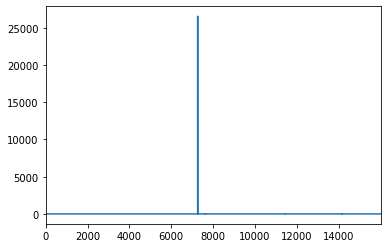

In [24]:
krl_final['overview_page_views'].plot()

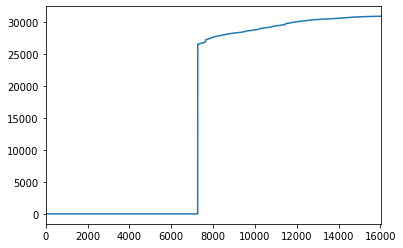

In [25]:
krl['overview_page_views'].plot()

## TURN CUMMULATIVE DATA INTO TIME SERIES DATA

...These are the data variables that are determined to be cummulative as per ivnestivation and with Cryptocompare.

In [29]:
c_vars = ['code_repo_forks','fb_likes']+market
# c_vars

In [30]:
def replaceCseries(df:pd.DataFrame, varlist:list=[]):
    '''
    Replace the variables which are cummulative series with their Time series counterpart 
    :param df: Dataframe to be processed, must contain variable Time as Unix series
    :param varlist: The list of varibles to be turned into time series
    Return the DF with the specified C-series turned into T-series
    '''
    orig_cols = df.columns.tolist()
    #Separate the "good" vs "bad" parts
    kept_list = list(set(orig_cols) - set(varlist))
    df_tba = df[kept_list]
    #Transform into time series
    x = getSocialDelta(df[['time']+varlist], 1)
    x = x.rename(columns = {'time':'time2'})
    f = pd.merge(left=df_tba, left_on='time',right=x,right_on='time2',how='left')
    f = f.drop('time2',axis=1)[orig_cols]
    return f 

In [31]:
krl_t = replaceCseries(krl,c_vars)

In [32]:
krl_t[1950:1955]

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
1950,1527174000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,2018-05-24 08:00:00,2018-05-24 15:00:00+00:00
1951,1527177600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,2018-05-24 09:00:00,2018-05-24 16:00:00+00:00
1952,1527181200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,2018-05-24 10:00:00,2018-05-24 17:00:00+00:00
1953,1527184800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,2018-05-24 11:00:00,2018-05-24 18:00:00+00:00
1954,1527188400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,2018-05-24 12:00:00,2018-05-24 19:00:00+00:00


In [33]:
krl[1950:1955]

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
1950,1527174000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-05-24 08:00:00,2018-05-24 15:00:00+00:00
1951,1527177600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-05-24 09:00:00,2018-05-24 16:00:00+00:00
1952,1527181200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-05-24 10:00:00,2018-05-24 17:00:00+00:00
1953,1527184800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-05-24 11:00:00,2018-05-24 18:00:00+00:00
1954,1527188400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,2018-05-24 12:00:00,2018-05-24 19:00:00+00:00


**Now we can apply getSocialData on krl_t because every variable is a proper time series itself**

Write wrapper function to: 
    1. Transform every variable into time series
    2. Append the delta variables for t=1,2,3,...,15

In [34]:
def appendDelta(base:pd.DataFrame, delta: int=1, c_vars = []):
    '''
    Process the base df and append the variables that denote the difference in values
    for t up to [delta] days. 
    :param base: pandas Dataframe that contains mixed series
    :param delta: The number of days to go back in time 
    :param c_vars: List of Cummulative Variables
    '''
    if delta < 1: 
        print('Time delta must be an integer greater than 1')
        return None
    #1. Covert C series into T series
    base_t = replaceCseries(base, c_vars)
    src = base_t.copy()
    #2. Create the base table
    for t in range(1,delta+1):
        drop_cols = ['date','date_utc']
        d = getSocialDelta(src,t,drop_cols)
        d.drop(drop_cols, axis=1, inplace=True)
        #2. Append the columns
        base_t = pd.merge(left=base_t,left_on='time',right=d,right_on='time',how='left',suffixes=('','_d'+str(t)))
    return base_t

In [35]:
x = appendDelta(krl,5 ,c_vars)
x.shape
x.head()

,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc,comments_d1,posts_d1,followers_d1,points_d1,overview_page_views_d1,analysis_page_views_d1,markets_page_views_d1,charts_page_views_d1,trades_page_views_d1,forum_page_views_d1,influence_page_views_d1,total_page_views_d1,fb_likes_d1,fb_talking_about_d1,twitter_followers_d1,twitter_following_d1,twitter_lists_d1,twitter_favourites_d1,twitter_statuses_d1,reddit_subscribers_d1,reddit_active_users_d1,reddit_posts_per_hour_d1,reddit_posts_per_day_d1,reddit_comments_per_hour_d1,reddit_comments_per_day_d1,code_repo_stars_d1,code_repo_forks_d1,code_repo_subscribers_d1,code_repo_open_pull_issues_d1,code_repo_closed_pull_issues_d1,code_repo_open_issues_d1,code_repo_closed_issues_d1,code_repo_contributors_d1,comments_d2,posts_d2,followers_d2,points_d2,overview_page_views_d2,analysis_page_views_d2,markets_page_views_d2,charts_page_views_d2,trades_page_views_d2,forum_page_views_d2,influence_page_views_d2,total_page_views_d2,fb_likes_d2,fb_talking_about_d2,twitter_followers_d2,twitter_following_d2,twitter_lists_d2,twitter_favourites_d2,twitter_statuses_d2,reddit_subscribers_d2,reddit_active_users_d2,reddit_posts_per_hour_d2,reddit_posts_per_day_d2,reddit_comments_per_hour_d2,reddit_comments_per_day_d2,code_repo_stars_d2,code_repo_forks_d2,code_repo_subscribers_d2,code_repo_open_pull_issues_d2,code_repo_closed_pull_issues_d2,code_repo_open_issues_d2,code_repo_closed_issues_d2,code_repo_contributors_d2,comments_d3,posts_d3,followers_d3,points_d3,overview_page_views_d3,analysis_page_views_d3,markets_page_views_d3,charts_page_views_d3,trades_page_views_d3,forum_page_views_d3,influence_page_views_d3,total_page_views_d3,fb_likes_d3,fb_talking_about_d3,twitter_followers_d3,twitter_following_d3,twitter_lists_d3,twitter_favourites_d3,twitter_statuses_d3,reddit_subscribers_d3,reddit_active_users_d3,reddit_posts_per_hour_d3,reddit_posts_per_day_d3,reddit_comments_per_hour_d3,reddit_comments_per_day_d3,code_repo_stars_d3,code_repo_forks_d3,code_repo_subscribers_d3,code_repo_open_pull_issues_d3,code_repo_closed_pull_issues_d3,code_repo_open_issues_d3,code_repo_closed_issues_d3,code_repo_contributors_d3,comments_d4,posts_d4,followers_d4,points_d4,overview_page_views_d4,analysis_page_views_d4,markets_page_views_d4,charts_page_views_d4,trades_page_views_d4,forum_page_views_d4,influence_page_views_d4,total_page_views_d4,fb_likes_d4,fb_talking_about_d4,twitter_followers_d4,twitter_following_d4,twitter_lists_d4,twitter_favourites_d4,twitter_statuses_d4,reddit_subscribers_d4,reddit_active_users_d4,reddit_posts_per_hour_d4,reddit_posts_per_day_d4,reddit_comments_per_hour_d4,reddit_comments_per_day_d4,code_repo_stars_d4,code_repo_forks_d4,code_repo_subscribers_d4,code_repo_open_pull_issues_d4,code_repo_closed_pull_issues_d4,code_repo_open_issues_d4,code_repo_closed_issues_d4,code_repo_contributors_d4,comments_d5,posts_d5,followers_d5,points_d5,overview_page_views_d5,analysis_page_views_d5,markets_page_views_d5,charts_page_views_d5,trades_page_views_d5,forum_page_views_d5,influence_page_views_d5,total_page_views_d5,fb_likes_d5,fb_talking_about_d5,twitter_followers_d5,twitter_following_d5,twitter_lists_d5,twitter_favourites_d5,twitter_statuses_d5,reddit_subscribers_d5,reddit_active_users_d5,reddit_posts_per_hour_d5,reddit_posts_per_day_d5,reddit_comments_per_hour_d5,reddit_comments_per_day_d5,code_repo_stars_d5,code_repo_forks_d5,code_repo_subscribers_d5,c

After verifying that that the data comes out with the correct shape, mass implement and save the prossed file 
with the **prefix** processed_

In [36]:
print(x.filter(regex='d4').columns.shape)

(33,)


In [ ]:
#The number of columns seems correct!!
36 + 5*33

# PART 2. NORMALIZE DATA INDEPENDENTLY IN EACH DATA SET

In [37]:
from sklearn.model_selection import train_test_split as tsplit
from sklearn.preprocessing import MinMaxScaler

p = pd.read_pickle("../pump_data_with_social.pkl")[['timestamp','pumptime_edited']]
p.sort_values('timestamp', inplace=True)

In [38]:
p.drop_duplicates(inplace=True)
p.reset_index(drop=True, inplace=True)
p.iloc[300:305]

,timestamp,pumptime_edited
300,1559314775,2019-05-31 14:59:35+00:00
301,1559406986,2019-06-01 16:36:26+00:00
302,1559483796,2019-06-02 13:56:36+00:00
303,1559491209,2019-06-02 16:00:09+00:00
304,1559509235,2019-06-02 21:00:35+00:00


We will use the date **May 31st at 12:00 AM** (beginning of day) as the cut off date
Timestamp: 1559260800

### Test on a single coin first

In [ ]:
# ae = pd.read_pickle("../../Social_Data/Daily/Processed_Data/Daily_AE_190978_d14.pkl")
# ae = ae.reset_index(drop=True)

In [ ]:
# ae_train = ae.loc[ae.time <= 1559260800]
# ae_test  = ae.loc[ae.time > 1559260800]
# print("Train set shape: {}, Test set shape: {}".format(ae_train.shape, ae_test.shape))
# ae.columns
# ae.head(2)

In [ ]:
# features = ['comments', 'posts', 'followers', 'points', 'overview_page_views',
#        'analysis_page_views', 'markets_page_views', 'charts_page_views',
#        'trades_page_views', 'forum_page_views', 'influence_page_views',
#        'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
#        'twitter_following', 'twitter_lists', 'twitter_favourites',
#        'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
#        'reddit_posts_per_hour', 'reddit_posts_per_day',
#        'reddit_comments_per_hour', 'reddit_comments_per_day',
#        'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
#        'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
#        'code_repo_open_issues', 'code_repo_closed_issues',
#        'code_repo_contributors']
# not_features = list(set(ae.columns) - set(features))
# print("There are {} features, and {} leftover variables".format(len(features),len(not_features)))

In [ ]:
# mmscaler = MinMaxScaler()
# mmscaler.fit(ae_train[features])
# print(mmscaler.min_)

In [ ]:
# train1 = mmscaler.transform(ae_train[features])
# train2 = ae_train[not_features].values
# ae_train_t = pd.DataFrame(np.concatenate((train1,train2),axis=1), columns=features+not_features)

In [ ]:
# test1 = mmscaler.transform(ae_test[features])
# test2 = ae_test[not_features].values
# ae_test_t = pd.DataFrame(np.concatenate((test1,test2),axis=1), columns=features+not_features)

In [ ]:
# ae_test_t.head(3)

In [ ]:
# ae_test.head(3)

In [39]:
def minmaxNorm(df: pd.DataFrame, cutoff :int, features:list):
    '''
    Split the input dataframe between training and testing at the cutoff and and apply 
    Min-max Normalization from Scikit-learn
    :param df: the input Dataframe with variable timestamp as integer
    :cutoff df: the timestamp to split between Training and testing
                If cutoff = 0, then we normalize the entire dataset
    :param features: a list of variables name to be transformed
    '''
    p = df.copy().sort_values('time')
    p = p.reset_index(drop=True)
    not_features = list(set(p.columns) - set(features))
    mmscaler = MinMaxScaler()
    if cutoff > 0:
      
        p_train = p.loc[p.time <= cutoff]
        p_test  = p.loc[p.time > cutoff]
        print("Train set shape: {}, Test set shape: {}".format(p_train.shape, p_test.shape))

        mmscaler.fit(p_train[features])

        train1 = mmscaler.transform(p_train[features])
        train2 = p_train[not_features].values
        p_train_t = pd.DataFrame(np.concatenate((train1,train2),axis=1), columns=features+not_features)
        p_train_t['train'] = 1

        test1 = mmscaler.transform(p_test[features])
        test2 = p_test[not_features].values
        p_test_t = pd.DataFrame(np.concatenate((test1,test2),axis=1), columns=features+not_features)
        p_test_t['train'] = 0

        #Stack them on top of each other; 
        r = p_train_t.append(p_test_t,ignore_index=True )
        r = r.reset_index(drop=True)
        return r 
    else: 
        print("Data shape: {}".format(p.shape))
        mmscaler.fit(p[features])
        ps = mmscaler.transform(p[features])
        ps2 = p[not_features].values
        r = pd.DataFrame(np.concatenate((ps,ps2),axis=1), columns=features+not_features)
        return r 

In [41]:
ae = pd.read_pickle("../../Social_Data/Hourly/Hourly_AE_190978.pkl")
ae = ae.reset_index(drop=True)

In [42]:
# minmaxNorm(ae, 0, features)

# Part 3: BATCH PROCESS

In [43]:
#These are the features to turn into True time series
features = ['comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues',
       'code_repo_contributors']

### Process HOURLY Data

In [45]:
dir_preffix = '../../Social_Data/Hourly'
c_vars = ['code_repo_forks','fb_likes']+market
social_error = []
for filename in os.listdir(dir_preffix):
    if 'pkl' in filename and error not in filename:
        #Memorize filename for appending later 
        _,coin_name,coin_id  =  filename.split('_')
        coin_id = coin_id[:-4]
        f = pd.read_pickle(dir_preffix+'/'+filename).reset_index(drop=True).drop_duplicates()
        #We go back 31 days before
        new_filename = filename.replace('.pkl','') + '_Time.pkl'
        print(new_filename)
        try: 
            #Replace the data as time series
            f_t = replaceCseries(f,c_vars)
            f_t['coin_name'] = coin_name
            f_t['coin_id'] = coin_id
            f_t.to_pickle(dir_preffix + '/Processed Data/Time Series/'+new_filename)
            # CANCELLED: DO NOT NORMALIZE HERE YET
#             Normalize the time series
#             n = minmaxNorm(f_t,1559260800,features)
#             n.to_pickle(dir_preffix + '/Processed Data/Normalized Series/Minmax_'+new_filename)
        except: 
            social_error.append(filename)
            continue

Hourly_COAL_453581_Time.pkl
Hourly_DAI_932637_Time.pkl
Hourly_KING_196560_Time.pkl
Hourly_MTH_208914_Time.pkl
Hourly_XRP_5031_Time.pkl
Hourly_MANA_199148_Time.pkl
Hourly_XPTX_385933_Time.pkl
Hourly_SEL_41967_Time.pkl
Hourly_VIB_198710_Time.pkl
Hourly_NAV_4571_Time.pkl
Hourly_CRPT_710597_Time.pkl
Hourly_MNE_84831_Time.pkl
Hourly_PTOY_129035_Time.pkl
Hourly_BRX_299415_Time.pkl
Hourly_NPXS_731516_Time.pkl
Hourly_ZNY_8762_Time.pkl
Hourly_SSH_885637_Time.pkl
Hourly_POA_793845_Time.pkl
Hourly_NCASH_792548_Time.pkl
Hourly_UFR_404806_Time.pkl
Hourly_EQT_105263_Time.pkl
Hourly_CNO_42438_Time.pkl
Hourly_KMD_26132_Time.pkl
Hourly_DYN_131111_Time.pkl
Hourly_KRL_877048_Time.pkl
Hourly_ALGO_930992_Time.pkl
Hourly_ETT_62529_Time.pkl
Hourly_WABI_340940_Time.pkl
Hourly_CVC_139467_Time.pkl
Hourly_GTO_517477_Time.pkl
Hourly_ICN_25921_Time.pkl
Hourly_AGI_710156_Time.pkl
Hourly_TAJ_57750_Time.pkl
Hourly_XBP_710087_Time.pkl
Hourly_GAM_6102_Time.pkl
Hourly_ZIL_716725_Time.pkl
Hourly_CURE_5387_Time.pkl
Hourly

Hourly_ARDR_30173_Time.pkl
Hourly_ARK_32699_Time.pkl


In [46]:
social_error

['hourly_social_error.pkl']

# Test a processed file

### HOURLY

In [64]:
t = pd.read_pickle("../../Social_Data/Hourly/Hourly_AE_190978.pkl").reset_index(drop=True).drop_duplicates()
print(t.shape)
t[-3:]

(16001, 36)


,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc
16005,1577746800,120,75,308,10775,30899,795,2118,3082,763,2847,307,40811,2718,78,25269,301,597,4414,3732,6354,2482,0.06,1.42,0.07,1.72,852,191,138,13,2640,65,378,52,2019-12-30 15:00:00,2019-12-30 23:00:00+00:00
16006,1577750400,120,75,308,10775,30899,795,2118,3082,763,2847,307,40811,2718,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,191,138,13,2640,65,378,52,2019-12-30 16:00:00,2019-12-31 00:00:00+00:00
16007,1577754000,120,75,308,10775,30899,795,2118,3082,763,2847,307,40811,2718,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,191,138,13,2640,65,378,52,2019-12-30 17:00:00,2019-12-31 01:00:00+00:00


In [66]:
t_n = pd.read_pickle("../../Social_Data/Hourly/Processed Data/Time Series/Hourly_AE_190978_Time.pkl")
print(t_n.shape)
t_n[-3:]

(16001, 38)


,time,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,date,date_utc,coin_name,coin_id
15998,1577746800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,25269,301,597,4414,3732,6354,2482,0.06,1.42,0.07,1.72,852,0.0,138,13,2640,65,378,52,2019-12-30 15:00:00,2019-12-30 23:00:00+00:00,AE,190978
15999,1577750400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,0.0,138,13,2640,65,378,52,2019-12-30 16:00:00,2019-12-31 00:00:00+00:00,AE,190978
16000,1577754000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,25270,301,597,4414,3732,6354,3072,0.06,1.42,0.07,1.72,852,0.0,138,13,2640,65,378,52,2019-12-30 17:00:00,2019-12-31 01:00:00+00:00,AE,190978


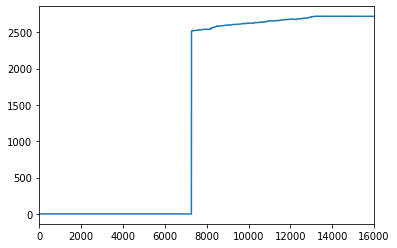

In [67]:
t.fb_likes.plot()

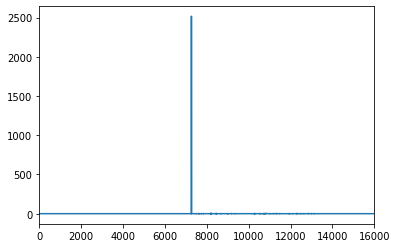

In [68]:
t_n.fb_likes.plot()